[INFO] Loading cached data for MSFT from /home/andreas/Software/genaiadvisor/code/data/MSFT_10y.csv


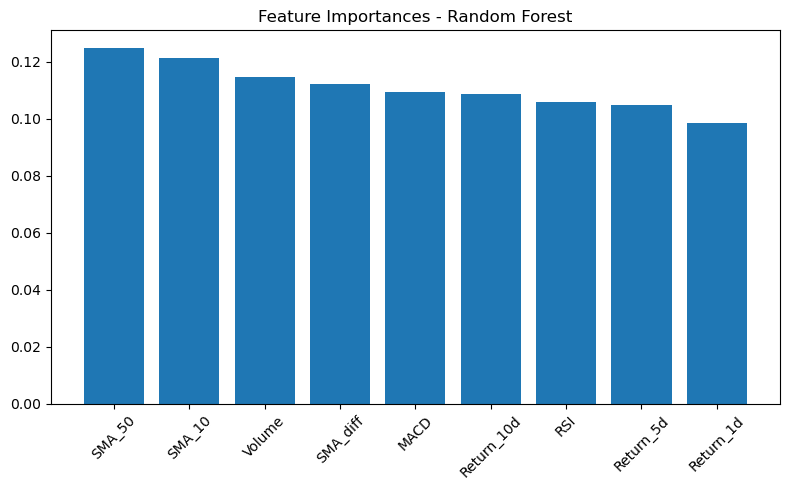

In [14]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

# Load model and scaler
rf_model = joblib.load("models/rf_model.pkl")  # adjust path if needed
scaler = joblib.load("models/scaler.pkl")

# Load data
from app.strategy_engine.ml_classifier import fetch_ticker_data, compute_features

df = fetch_ticker_data("MSFT", period="1y")
features_df = compute_features(df)
features = features_df[['SMA_10', 'SMA_50', 'SMA_diff', 'RSI', 'MACD',
                        'Return_1d', 'Return_5d', 'Return_10d', 'Volume']]
feature_names = features.columns.tolist()

# Scale features
features_scaled = scaler.transform(features)

# 1️⃣ Feature Importance Plot
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.title("Feature Importances - Random Forest")
plt.bar(range(features_scaled.shape[1]), importances[indices], align='center')
plt.xticks(range(features_scaled.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


# 2️⃣ SHAP Analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(features_scaled)

# SHAP summary bar plot
shap.summary_plot(shap_values, features, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("shap_summary_bar.png")
plt.close()

# SHAP dot summary plot (feature impact + value colour)
shap.summary_plot(shap_values, features, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig("shap_summary_dot.png")
plt.close()



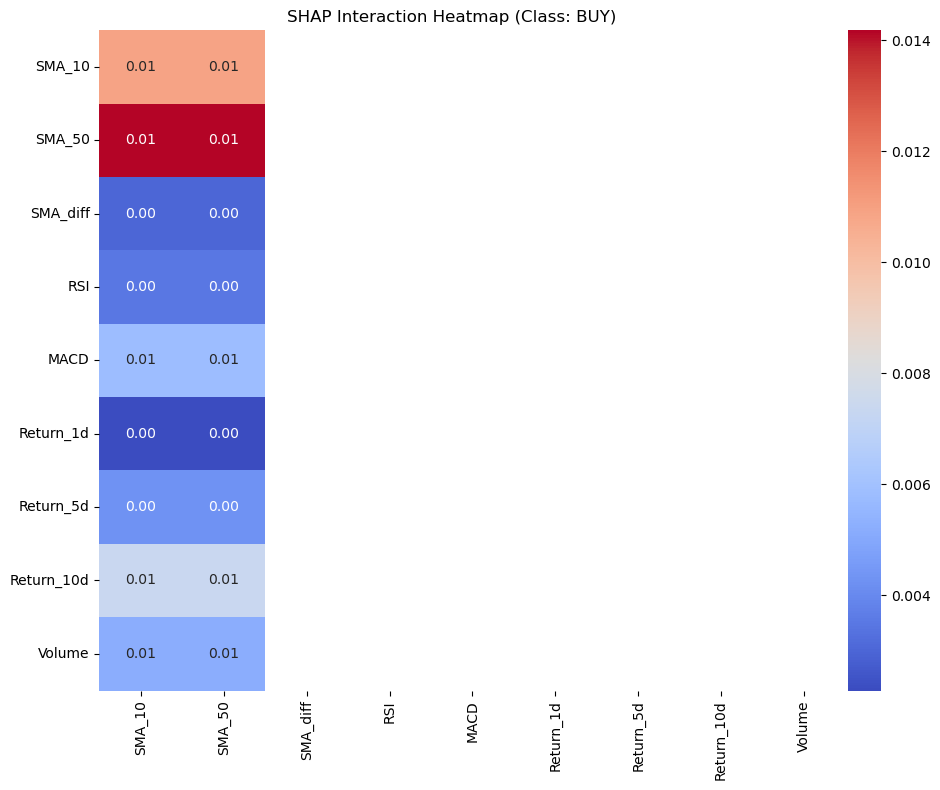

In [15]:
# Use only class 1 (BUY signal) interaction values
interaction_values = shap_interaction_values[1]  # [samples, features, features]

# Reduce across samples (axis=0) by mean of absolute values
interaction_importance = np.abs(interaction_values).mean(axis=0)

# Plot as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(interaction_importance,
            xticklabels=feature_names,
            yticklabels=feature_names,
            cmap="coolwarm", annot=True, fmt=".2f")

plt.title("SHAP Interaction Heatmap (Class: BUY)")
plt.tight_layout()
plt.savefig("shap_interaction_heatmap.png")
plt.show()
